In [2]:
import pyparax as parax
import numpy as np 
import pandas as pd
import scipy as sp
from math import pi
import matplotlib.pyplot as plt
import cmath
from scipy.optimize import leastsq

In [3]:
field_center = np.loadtxt('E_20.csv',delimiter=',',dtype=complex)

In [4]:
field_center = field_center[22-16:20+14,44-16:40+16]

In [5]:
lambda_= 1.3e-10
pitch = 3e-4/64
grid_dim = 28
window_extent = pitch*grid_dim

In [6]:
def param_se(pfit,pcov,x,y,function):
    err_f = lambda pfit,x,y:y-function(x,*pfit)
    var_res = np.sum((err_f(pfit,x,y))**2)/(len(y)-len(pcov))
    param_se = np.array([np.sqrt(pcov[i,i]*var_res) for i in range(len(pcov))])
    return param_se

def bootstrap_param_se(pfit,pcov,x,y,function):
    err_f = lambda pfit,x,y:y-function(x,*pfit)
    res_se = np.std(err_f(pfit,x,y))
    bootstrap_se_lst = []
    for i in range(100):
        y_random_err = np.random.normal(0,res_se,len(y))
        y_random = y+y_random_err
        random_fit,_ = leastsq(err_f,pfit,args=(x,y_random))
        bootstrap_se_lst.append(random_fit)
    param_se = np.std(np.array(bootstrap_se_lst),axis=0)
    return param_se


In [7]:
def get_amp_i_fit(marg_pmf,l,bootstrap):
    Ei = np.sum(marg_pmf*l)
    p0 = [1e-5,Ei,1e-5]
    pfit,pcov = leastsq(marg_residual,p0,args=(l,marg_pmf),full_output=1)[:2]
    if bootstrap:
        pse = bootstrap_param_se(pfit,pcov,l,marg_pmf,marg_fit)
    else:
        pse = param_se(pfit,pcov,l,marg_pmf,marg_fit)
        
    if np.all(pfit!=None):
        return pfit,pse
    else:
        return np.nan*np.ones(3),np.nan*np.ones(3)

def marg_residual(p,x,marg_pmf):
    A,x0,w = p
    marg_hat = marg_fit(x,A,x0,w)
    return marg_pmf - marg_hat

def marg_fit(x,A,x0,w):
    return A*np.exp(-(x-x0)**2/w**2)/w


In [8]:
def fit_astigmatic_field(fi,bootstrap,grid_dim):
    abs_fi = np.abs(fi)
    pmf = abs_fi/np.sum(abs_fi)
    fi_window_extent = window_extent*fi.shape[0]/grid_dim
    l = np.linspace(-fi_window_extent/2,fi_window_extent/2,fi.shape[0])
    marg_x = np.sum(pmf,axis=0)
    marg_y = np.sum(pmf,axis=1)
    pfit_amp_x,pse_amp_x = get_amp_i_fit(marg_x,l,bootstrap)
    pfit_amp_y,pse_amp_y = get_amp_i_fit(marg_y,l,bootstrap) 
    #Ex = np.sum(l*marg_x)
    #Ey = np.sum(l*marg_y)
    return pfit_amp_x,pse_amp_x,pfit_amp_y,pse_amp_y

def prop_astigmatic_fit(E,grid_dim,padded_dim,prop_len=20000,step_size=250,full_output=False,bootstrap=False):
    parax.numeric_parameters.wavelength=lambda_*1000
    parax.numeric_parameters.dx = 1000*window_extent/grid_dim
    parax.numeric_parameters.dy = 1000*window_extent/grid_dim
    parax.numeric_parameters.dz = step_size
    parax.numeric_parameters.N_x = padded_dim
    parax.numeric_parameters.N_y = padded_dim
    parax.numeric_parameters.N_z = prop_len//step_size
    f0 = 1j*np.zeros((padded_dim,padded_dim))
    center = E.reshape((grid_dim,grid_dim))
    f0[padded_dim//2-grid_dim//2:padded_dim//2+grid_dim//2,padded_dim//2-grid_dim//2:padded_dim//2+grid_dim//2] = center
    system = [prop_len]
    f = parax.experimental_simulator.experimental_simulator_2d.propagate(f0, system, output_full = True, forward = False, print_output=True)
    fit_amp_x_lst = []
    fit_amp_y_lst = []
    se_amp_x_lst = []
    se_amp_y_lst = []
    f_proper = []
    for i,fi in enumerate(f):
        fi_subset = fi#[padded_dim//2-grid_dim//2:padded_dim//2+grid_dim//2,padded_dim//2-grid_dim//2:padded_dim//2+grid_dim//2]
        pfit_amp_x,pse_amp_x,pfit_amp_y,pse_amp_y = fit_astigmatic_field(fi_subset,bootstrap,grid_dim)
        fit_amp_x_lst.append(pfit_amp_x)
        fit_amp_y_lst.append(pfit_amp_y)
        se_amp_x_lst.append(pse_amp_x)
        se_amp_y_lst.append(pse_amp_y)
        f_proper.append(fi_subset)
    if full_output:
        return fit_amp_x_lst,se_amp_x_lst,fit_amp_y_lst,se_amp_y_lst,f
    else:
        return fit_amp_x_lst,se_amp_x_lst,fit_amp_y_lst,se_amp_y_lst

In [9]:
# End of propagation
z = 2*28*pitch**2/lambda_


In [10]:
N_F = (window_extent/2)**2/(lambda_*z)
N_F

3.5

In [11]:
M = 90
Q = M/(4*N_F)
Q

6.428571428571429

In [12]:
N = int(np.ceil(Q*M))
N

579

In [13]:
N = N+1

According to Fig. 5.5 in Goodman, we should go for $grid\_dim = 90$, which is the adjustment to using $M$ now, for aliasing of $0.01$ the peak value at the edges. That means we need a spline to adjust sampling.  As we see in the image below though, this grid $28x28$ isn't really the full extent of the actual samples since it's actually zero padded.  That may result in some additional aliasing with the spectral island being actually larger in reality

Text(0.5, 1.0, 'amp')

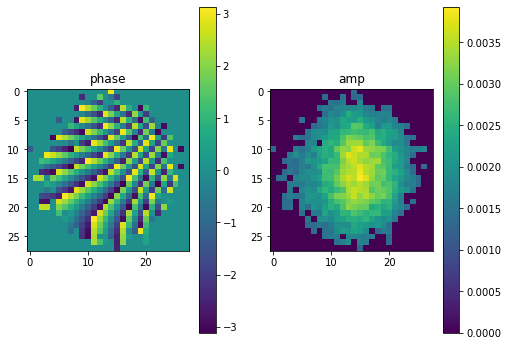

In [82]:
plt.figure(figsize=(8,6))
plt.subplot(1,2,1)
plt.imshow(np.angle(field_center))
plt.title('phase')
plt.colorbar()
plt.subplot(1,2,2)
plt.imshow(np.abs(field_center))
plt.colorbar()
plt.title('amp')

In [15]:
window_extent = pitch*field_center.shape[0]

In [87]:
from scipy.interpolate import interp2d
# have to separately interpolate real and imag
x = np.linspace(-window_extent/2,window_extent/2,field_center.shape[0])
y = x
u_spline_real = interp2d(x,y,np.real(field_center),kind='cubic')
u_spline_imag = interp2d(x,y,np.imag(field_center),kind='cubic')

In [88]:
x_M = np.linspace(-window_extent/2,window_extent/2,M)
y_M = x_M
field_center_real = u_spline_real(x_M,y_M)
field_center_imag = u_spline_imag(x_M,y_M)

Text(0.5, 1.0, 'imag')

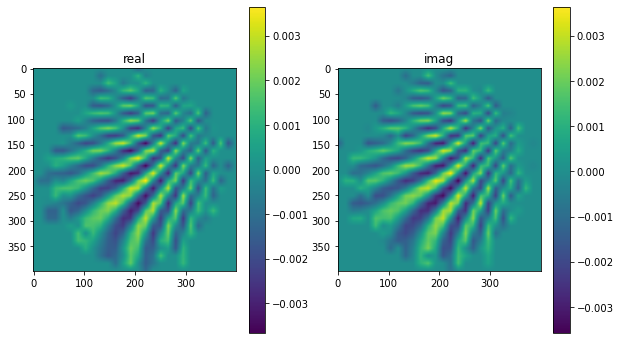

In [78]:
plt.figure(figsize=(10,6))
plt.subplot(1,2,1)
plt.imshow(field_center_real)
plt.title('real')
plt.colorbar()
plt.subplot(1,2,2)
plt.imshow(field_center_imag)
plt.colorbar()
plt.title('imag')

In [89]:
field_center_M = field_center_real+1j*field_center_imag

Text(0.5, 1.0, 'phase')

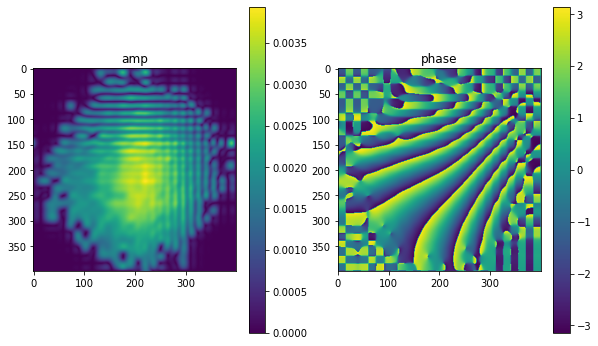

In [91]:
plt.figure(figsize=(10,6))
plt.subplot(1,2,1)
plt.imshow(np.abs(field_center_M))
plt.title('amp')
plt.colorbar()
plt.subplot(1,2,2)
plt.imshow(np.angle(field_center_M))
plt.colorbar()
plt.title('phase')

Text(0.5, 1.0, 'linear interp slice')

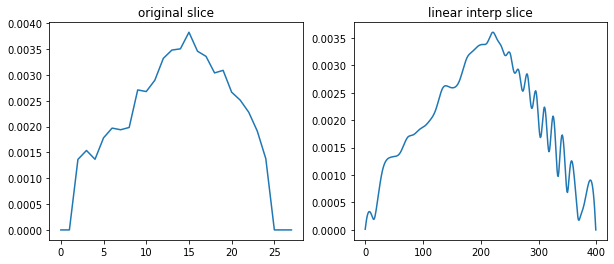

In [90]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(np.abs(field_center)[14])
plt.title('original slice')
plt.subplot(1,2,2)
plt.plot(np.abs(field_center_M)[M//2])
plt.title('linear interp slice')


In [22]:
# Now we pad according to N
field = 1j*np.zeros((N,N))
# M,N always selected to be even
field[N//2-M//2:N//2+M//2,N//2-M//2:N//2+M//2] = field_center_M

Text(0.5, 1.0, 'phase')

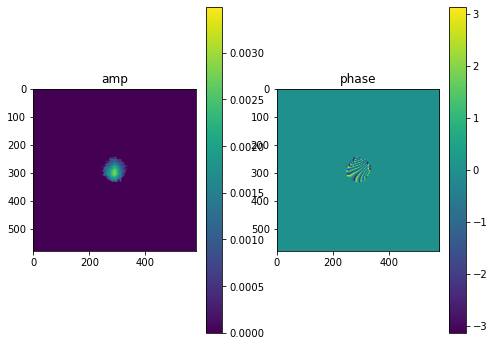

In [23]:
plt.figure(figsize=(8,6))
plt.subplot(1,2,1)
plt.imshow(np.abs(field))
plt.title('amp')
plt.colorbar()
plt.subplot(1,2,2)
plt.imshow(np.angle(field))
plt.colorbar()
plt.title('phase')

In [24]:
grid_dim = M

In [25]:
def wz_fit(z,w0,z0,wavelen):
    zR = pi*w0**2/wavelen
    return w0*(1+((z-z0)/zR)**2)**0.5

def wz_residual(p,z,w):
    w0,z0,wavelen = p
    w_hat = wz_fit(z,w0,z0,wavelen)
    return w-w_hat

def get_w0(w_arr,full_output=False,step_size=250,bootstrap=False):
    z = [i*step_size/1000 for i,w in enumerate(w_arr) if np.logical_not(np.isnan(w))]
    w = w_arr[np.logical_not(np.isnan(w_arr))]
    p0 = [0.01,30,lambda_]
    pfit,pcov = leastsq(wz_residual,p0,args=(z,w),full_output=1)[:2]
    if bootstrap:
        pse = bootstrap_param_se(pfit,pcov,z,w,wz_fit)
    else:
        pse = param_se(pfit,pcov,z,w,wz_fit)
    if full_output:
        plt.plot(z,np.abs(w))
        plt.plot(z,wz_fit(z,*pfit))
        plt.xlabel('$\Delta z$ (m)')
        plt.ylabel('$w(z)$ (m)')
        return pfit,pse
    else:
        return pfit,pse
    

In [26]:
fit_amp_x_lst,se_amp_x_lst,fit_amp_y_lst,se_amp_y_lst,f = prop_astigmatic_fit(field_center_M.flatten(),M,N,bootstrap=True,full_output=True,step_size=250,prop_len=9000)

[['normal', 'normal']]
Propagate for 9000 units [mm]
Step 0/36
Step 1/36
Step 2/36
Step 3/36
Step 4/36
Step 5/36
Step 6/36
Step 7/36
Step 8/36
Step 9/36
Step 10/36
Step 11/36
Step 12/36
Step 13/36
Step 14/36
Step 15/36
Step 16/36
Step 17/36
Step 18/36
Step 19/36
Step 20/36
Step 21/36
Step 22/36
Step 23/36
Step 24/36
Step 25/36
Step 26/36
Step 27/36
Step 28/36
Step 29/36
Step 30/36
Step 31/36
Step 32/36
Step 33/36
Step 34/36
Step 35/36


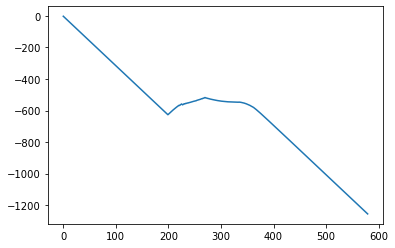

In [27]:
plt.plot(np.unwrap(np.angle(f[5][:,f.shape[1]//2])))

Text(0, 0.5, '$w_x(z)$ (m)')

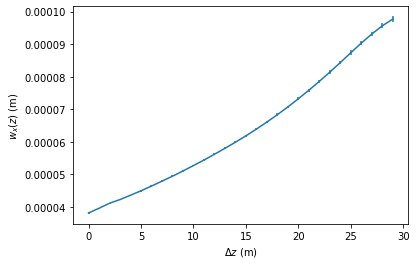

In [28]:
plt.errorbar(np.arange(len(fit_amp_x_lst))[:30],np.array(fit_amp_x_lst)[:30,2],yerr=np.array(se_amp_x_lst)[:30,2])
plt.xlabel('$\Delta z$ (m)')
plt.ylabel('$w_x(z)$ (m)')

Text(0, 0.5, '$w_y(z)$ (m)')

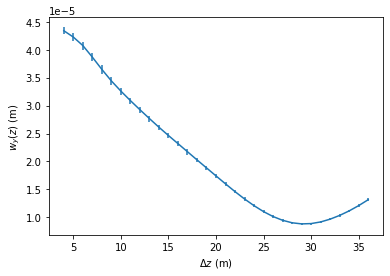

In [29]:
plt.errorbar(np.arange(len(fit_amp_y_lst))[4:],np.array(fit_amp_y_lst)[4:,2],yerr=np.array(se_amp_y_lst)[4:,2])
plt.xlabel('$\Delta z$ (m)')
plt.ylabel('$w_y(z)$ (m)')

In [30]:
z_c = (window_extent/M)**2*N/lambda_
z_c

9.488514957264957

w0y = 8.656945393476431e-06 , z0y = 3.6282564287736245 , wavelen = -1.7242756142484294e-10


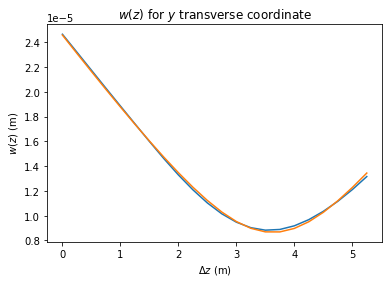

In [31]:
fit_w0y, se_w0y = get_w0(np.array(fit_amp_y_lst)[15:,2],bootstrap=True,full_output=True)
plt.title('$w(z)$ for $y$ transverse coordinate')
w0y,z0y,wavelen = fit_w0y
print('w0y =',w0y, ', z0y =',z0y,  ', wavelen =',wavelen)

In [32]:
# Full propagation dictates shortest z is 1

z = 1

In [33]:
N_F = (window_extent/2)**2/(lambda_*z)
N_F

33.12800480769231

In [34]:
M = 400
Q = M/(4*N_F)
Q

3.01859410430839

In [35]:
N = int(np.ceil(Q*M))
N

1208

In [36]:
x_M = np.linspace(-window_extent/2,window_extent/2,M)
y_M = x_M
field_center_real = u_spline_real(x_M,y_M)
field_center_imag = u_spline_imag(x_M,y_M)

Text(0.5, 1.0, 'imag')

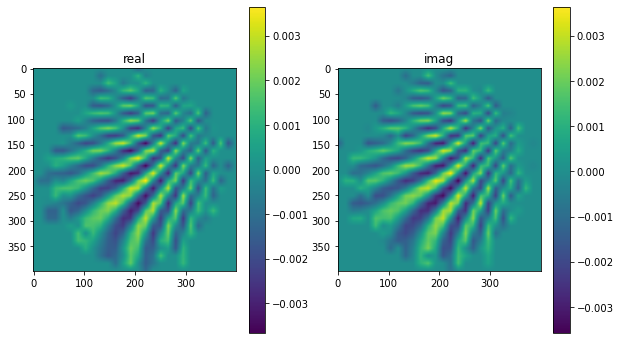

In [37]:
plt.figure(figsize=(10,6))
plt.subplot(1,2,1)
plt.imshow(field_center_real)
plt.title('real')
plt.colorbar()
plt.subplot(1,2,2)
plt.imshow(field_center_imag)
plt.colorbar()
plt.title('imag')

In [38]:
field_center_M = field_center_real+1j*field_center_imag

Text(0.5, 1.0, 'phase')

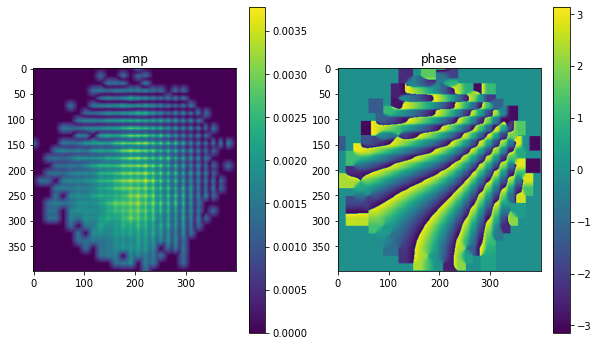

In [39]:
plt.figure(figsize=(10,6))
plt.subplot(1,2,1)
plt.imshow(np.abs(field_center_M))
plt.title('amp')
plt.colorbar()
plt.subplot(1,2,2)
plt.imshow(np.angle(field_center_M))
plt.colorbar()
plt.title('phase')

Text(0.5, 1.0, 'linear interp slice')

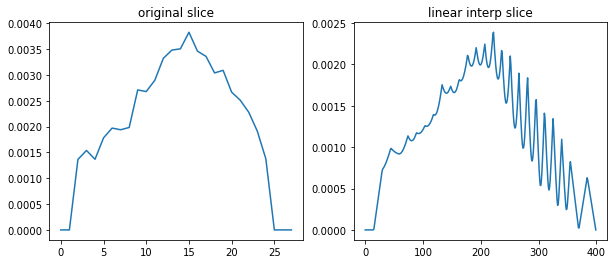

In [40]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(np.abs(field_center)[14])
plt.title('original slice')
plt.subplot(1,2,2)
plt.plot(np.abs(field_center_M)[M//2])
plt.title('linear interp slice')


In [41]:
# Now we pad according to N
field = 1j*np.zeros((N,N))
# M,N always selected to be even
field[N//2-M//2:N//2+M//2,N//2-M//2:N//2+M//2] = field_center_M

Text(0.5, 1.0, 'phase')

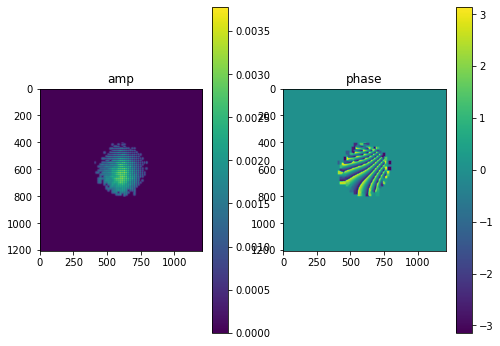

In [49]:
plt.figure(figsize=(8,6))
plt.subplot(1,2,1)
plt.imshow(np.abs(field))
plt.title('amp')
plt.colorbar()
plt.subplot(1,2,2)
plt.imshow(np.angle(field))
plt.colorbar()
plt.title('phase')

In [50]:
grid_dim = M

In [51]:
fit_amp_x_lst,se_amp_x_lst,fit_amp_y_lst,se_amp_y_lst,f = prop_astigmatic_fit(field_center_M.flatten(),M,N,bootstrap=True,full_output=True,step_size=1000,prop_len=9000)

[['normal', 'normal']]
Propagate for 9000 units [mm]
Step 0/9
Step 1/9
Step 2/9
Step 3/9
Step 4/9
Step 5/9
Step 6/9
Step 7/9
Step 8/9


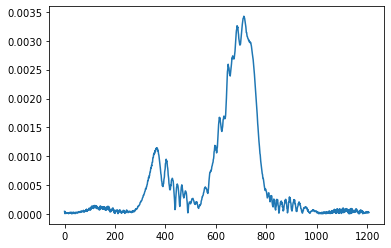

In [52]:
plt.plot(np.abs(f[3][:,f.shape[1]//2]))

Text(0, 0.5, '$w_x(z)$ (m)')

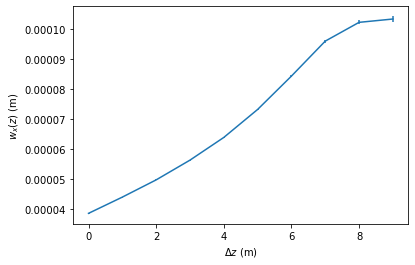

In [53]:
plt.errorbar(np.arange(len(fit_amp_x_lst))[:30],np.array(fit_amp_x_lst)[:30,2],yerr=np.array(se_amp_x_lst)[:30,2])
plt.xlabel('$\Delta z$ (m)')
plt.ylabel('$w_x(z)$ (m)')

Text(0, 0.5, '$w_y(z)$ (m)')

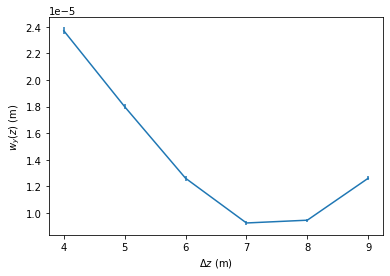

In [54]:
plt.errorbar(np.arange(len(fit_amp_y_lst))[4:],np.array(fit_amp_y_lst)[4:,2],yerr=np.array(se_amp_y_lst)[4:,2])
plt.xlabel('$\Delta z$ (m)')
plt.ylabel('$w_y(z)$ (m)')

In [55]:
z_c = (window_extent/M)**2*N/lambda_
z_c

1.0004657451923076

w0y = 8.363397934043743e-06 , z0y = 1.6128126783573418 , wavelen = 6.90357650081958e-10


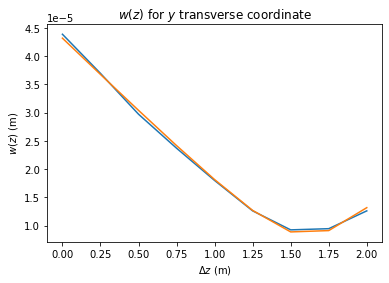

In [56]:
fit_w0y, se_w0y = get_w0(np.array(fit_amp_y_lst)[1:,2],bootstrap=True,full_output=True)
plt.title('$w(z)$ for $y$ transverse coordinate')
w0y,z0y,wavelen = fit_w0y
print('w0y =',w0y, ', z0y =',z0y,  ', wavelen =',wavelen)

In [57]:
fit_amp_x_lst,se_amp_x_lst,fit_amp_y_lst,se_amp_y_lst,f = prop_astigmatic_fit(field_center_M.flatten(),M,N,bootstrap=True,full_output=True,step_size=6000,prop_len=6000)

[['normal', 'normal']]
Propagate for 6000 units [mm]
Step 0/1


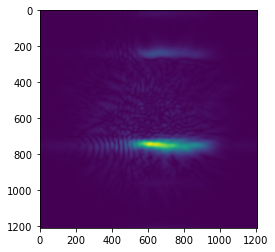

In [62]:
plt.imshow(np.abs(f[1]))